In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
#import geocoder
import os
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')
#Libraries imported.
#Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
#!conda install -c conda-forge geocoder --yes
!pip install conda geocoder

     |████████████████████████████████| 307kB 8.3MB/s eta 0:00:01
     |████████████████████████████████| 102kB 19.8MB/s ta 0:00:01
     |████████████████████████████████| 112kB 24.8MB/s eta 0:00:01
     |████████████████████████████████| 552kB 25.9MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a3/50/79/302742d53e2231ec545cb3791abfdd24de234021ed8e0588a0
Successfully built conda


In [12]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.
#Below function will return venue id , venue name and category.

In [28]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'KUZZDMMENEU1JDFSQZZZWOU0A23HLVRIL3Z0OSQOFE1P0ZPE' # changed my Foursquare ID
    CLIENT_SECRET = 'VMUGJKLRPHONQSUTHR2RLPFEDKIVDSQSGL0C4DBBUQ0FMW0N' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df


In [29]:
#Define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.


def get_venue_details(venue_id):
        
    CLIENT_ID = 'KUZZDMMENEU1JDFSQZZZWOU0A23HLVRIL3Z0OSQOFE1P0ZPE' # i have changed the id with ##
    CLIENT_SECRET = 'VMUGJKLRPHONQSUTHR2RLPFEDKIVDSQSGL0C4DBBUQ0FMW0N' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

#define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.


In [30]:

from pandas.io.json import json_normalize

In [31]:


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


#call the above funtion to get the new york city data.


# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


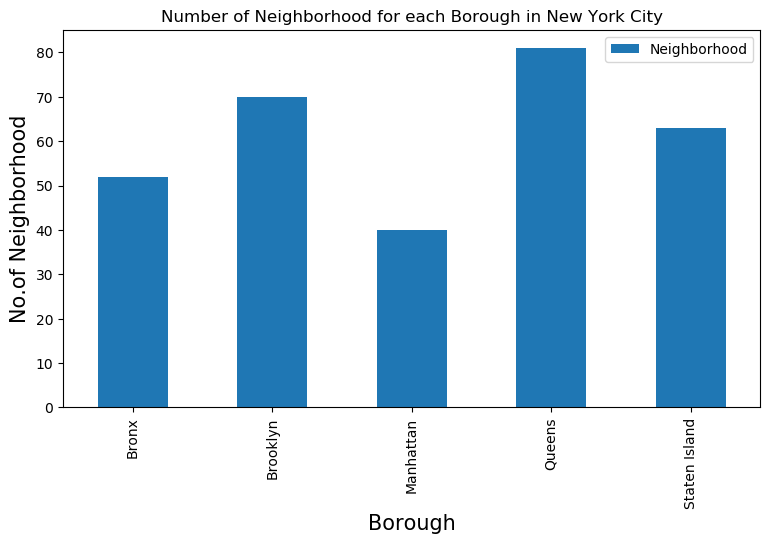

In [32]:
new_york_data.shape



plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [33]:
# collect Italian restaurants for each Neighborhood


# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(Italian_restaurants)))
    for restaurant_detail in Italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        Italian_rest_ny = Italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

KeyError: 'groups'

In [20]:
Italian_rest_ny.head()

Italian_rest_ny.shape

(0, 4)

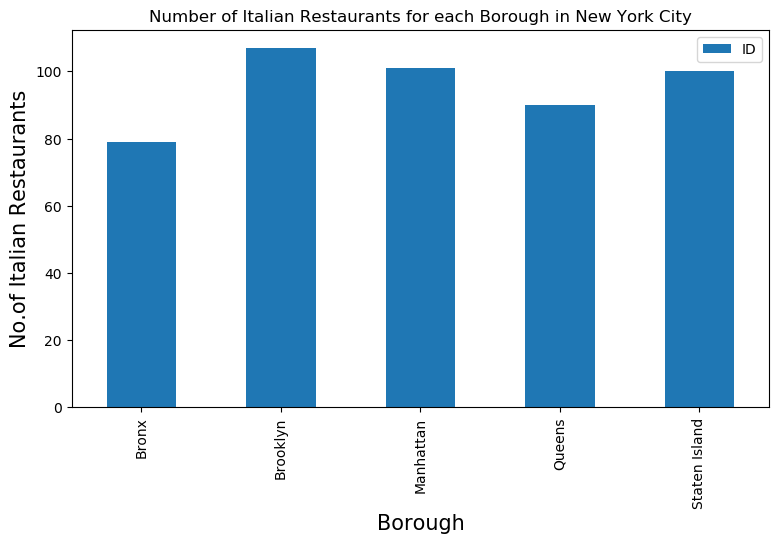

In [115]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
Italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

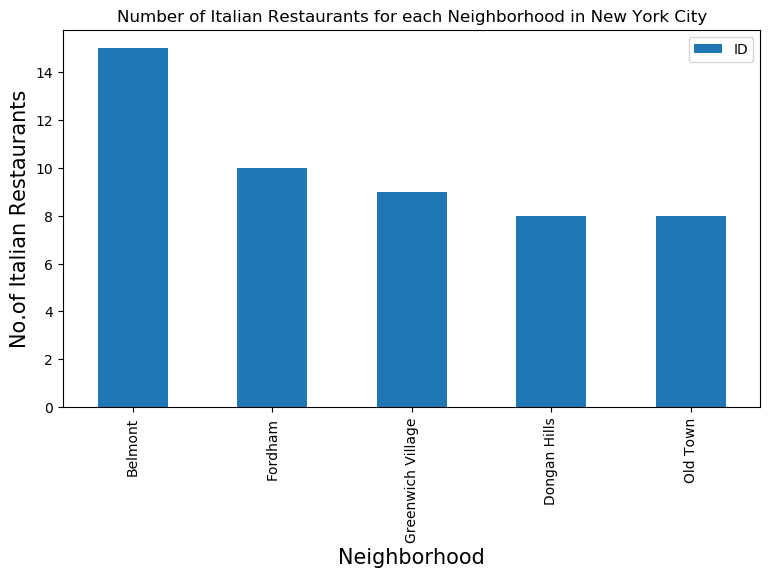

In [116]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
Italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [117]:
Italian_rest_ny[Italian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
339,Queens,Floral Park,4c450fae74ffc928328676cc,Luigi's Restaurant & Bar


In [128]:
# get the ranking of each restaurant for further analysis.

# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Italian_rest_ny),')','processed')
    Italian_rest_stats_ny = Italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

KeyError: 'venue'

In [122]:
Italian_rest_stats_ny.head()
Italian_rest_stats_ny.shape
Italian_rest_ny.shape

Italian_rest_stats_ny.to_csv('Italian_rest_stats_ny.csv', index=False)
Italian_rest_stats_ny_csv=pd.read_csv('Italian_rest_stats_ny.csv')
Italian_rest_stats_ny_csv.shape
Italian_rest_stats_ny_csv.head()
Italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
Borough         0 non-null object
Neighborhood    0 non-null object
ID              0 non-null object
Name            0 non-null object
Likes           0 non-null object
Rating          0 non-null object
Tips            0 non-null object
dtypes: object(7)
memory usage: 0.0+ bytes


In [123]:
#We see that values like Likes, Tips are strig values. We would need to convert them into float 

Italian_rest_stats_ny['Likes']=Italian_rest_stats_ny['Likes'].astype('float64')

Italian_rest_stats_ny['Tips']=Italian_rest_stats_ny['Tips'].astype('float64')

Italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
Borough         0 non-null object
Neighborhood    0 non-null object
ID              0 non-null object
Name            0 non-null object
Likes           0 non-null float64
Rating          0 non-null object
Tips            0 non-null float64
dtypes: float64(2), object(5)
memory usage: 0.0+ bytes


In [124]:
# Restaurant with maximum Likes
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Likes'].idxmax()]

ValueError: attempt to get argmax of an empty sequence

In [125]:
# Restaurant with maximum Rating
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Rating'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [126]:

# Restaurant with maximum Tips
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Tips'].idxmax()]

ValueError: attempt to get argmax of an empty sequence

In [127]:
ny_neighborhood_stats=Italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

KeyError: "['Rating'] not in index"

In [92]:

#************Above are the top neighborhoods with top average rating of Italian restaurant


ny_borough_stats=Italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.091304
1,Brooklyn,7.815789
0,Bronx,5.433333


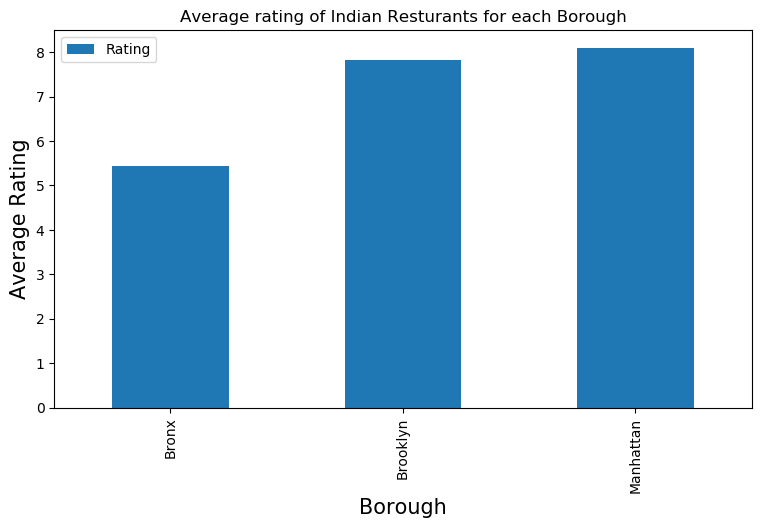

In [93]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [94]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

ny_neighborhood_stats

,Neighborhood,Average Rating
2,Central Harlem,8.00
3,Clinton Hill,8.80
5,East Flatbush,8.30
8,Fort Greene,8.80
10,Gramercy,8.55
17,Murray Hill,8.60
18,Ocean Hill,8.00
20,Prospect Heights,8.70
23,Roosevelt Island,8.50
24,South Side,8.40


In [95]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Central Harlem,40.815976,-73.943211,8.00
1,Brooklyn,Clinton Hill,40.693229,-73.967843,8.80
2,Brooklyn,East Flatbush,40.641718,-73.936103,8.30
3,Brooklyn,Fort Greene,40.688527,-73.972906,8.80
4,Manhattan,Gramercy,40.737210,-73.981376,8.55
5,Manhattan,Murray Hill,40.748303,-73.978332,8.60
6,Queens,Murray Hill,40.764126,-73.812763,8.60
7,Brooklyn,Ocean Hill,40.678403,-73.913068,8.00
8,Brooklyn,Prospect Heights,40.676822,-73.964859,8.70
9,Manhattan,Roosevelt Island,40.762160,-73.949168,8.50


In [96]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [97]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the restaurants and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [98]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [99]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [100]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
#ny_geo = r'Borough Boundaries.geojson'
ny_geo = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson"

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.3, 
    line_opacity=0.9,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
#ny_map.save('borough_rating.html')
ny_map